# Circuit Analysis - Grid Position Impact by Track

Analyzing how different circuits affect overtaking opportunities and grid position advantage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

%matplotlib inline

## Load Data

In [2]:
data_path = Path('../data/processed/processed_race_data.csv')

df_all = pd.read_csv(data_path)
df_finished = df_all[df_all['completed_race'] == True].copy()

print(f"Total records: {len(df_all):,}")
print(f"Finished races: {len(df_finished):,}")
print(f"Unique circuits: {df_all['circuit'].nunique()}")
print(f"Years: {sorted(df_all['year'].unique())}")

Total records: 780
Finished races: 359
Unique circuits: 21
Years: [np.int64(2018), np.int64(2019)]


## Circuit-Level Statistics

In [3]:
circuit_stats = []

for circuit in sorted(df_all['circuit'].unique()):
    circuit_data = df_all[df_all['circuit'] == circuit]
    finished_data = df_finished[df_finished['circuit'] == circuit]
    
    # Basic stats
    num_races = circuit_data['race_name'].nunique()
    total_entries = len(circuit_data)
    years_active = sorted(circuit_data['year'].unique())
    
    # Overtaking metrics
    if len(finished_data) > 0:
        avg_pos_change = finished_data['position_change'].abs().mean()
        std_pos_change = finished_data['position_change'].std()
        variance_pos_change = finished_data['position_change'].var()
        improved_pct = (finished_data['position_change'] > 0).mean() * 100
    else:
        avg_pos_change = std_pos_change = variance_pos_change = improved_pct = 0
    
    # Grid position importance
    pole_data = finished_data[finished_data['GridPosition'] == 1]
    pole_wins = (pole_data['Position'] == 1).sum()
    pole_win_rate = (pole_wins / len(pole_data) * 100) if len(pole_data) > 0 else 0
    
    if len(finished_data) > 0:
        correlation = finished_data['GridPosition'].corr(finished_data['Position'])
        avg_finish_from_pole = pole_data['Position'].mean() if len(pole_data) > 0 else 0
    else:
        correlation = 0
        avg_finish_from_pole = 0
    
    top3_grid = finished_data[finished_data['GridPosition'] <= 3]
    top3_wins = (top3_grid['Position'] == 1).sum()
    top3_win_rate = (top3_wins / num_races * 100) if num_races > 0 else 0
    
    # Race characteristics
    dnf_count = (circuit_data['is_dnf'] == True).sum()
    dnf_rate = (dnf_count / len(circuit_data) * 100) if len(circuit_data) > 0 else 0
    avg_dnfs_per_race = dnf_count / num_races if num_races > 0 else 0
    
    # Points from outside top 10 grid
    outside_top10 = finished_data[finished_data['GridPosition'] > 10]
    points_rate = (outside_top10['Position'] <= 10).mean() * 100 if len(outside_top10) > 0 else 0
    
    # Exceptional results
    exceptional_wins = len(finished_data[(finished_data['Position'] == 1) & 
                                         (finished_data['GridPosition'] >= 6)])
    exceptional_podiums = len(finished_data[(finished_data['Position'] <= 3) & 
                                            (finished_data['GridPosition'] >= 10)])
    
    circuit_stats.append({
        'circuit': circuit,
        'num_races': num_races,
        'total_entries': total_entries,
        'years_active': len(years_active),
        'avg_pos_change': avg_pos_change,
        'std_pos_change': std_pos_change,
        'variance_pos_change': variance_pos_change,
        'improved_pct': improved_pct,
        'pole_win_rate': pole_win_rate,
        'grid_finish_correlation': correlation,
        'avg_finish_from_pole': avg_finish_from_pole,
        'top3_win_rate': top3_win_rate,
        'avg_dnfs_per_race': avg_dnfs_per_race,
        'dnf_rate': dnf_rate,
        'points_from_p11plus': points_rate,
        'exceptional_wins': exceptional_wins,
        'exceptional_podiums': exceptional_podiums
    })

circuit_df = pd.DataFrame(circuit_stats)

print("Circuit Statistics Summary:")
print(circuit_df.to_string(index=False))

Circuit Statistics Summary:
          circuit  num_races  total_entries  years_active  avg_pos_change  std_pos_change  variance_pos_change  improved_pct  pole_win_rate  grid_finish_correlation  avg_finish_from_pole  top3_win_rate  avg_dnfs_per_race  dnf_rate  points_from_p11plus  exceptional_wins  exceptional_podiums
           Austin          1             20             1        3.625000        5.755432            33.125000     75.000000            0.0                 0.189519                   3.0          100.0               12.0      60.0           100.000000                 0                    1
             Baku          1             40             2        3.272727        3.156797             9.965368     68.181818           50.0                 0.872801                   2.5          200.0               18.0      45.0            62.500000                 0                    0
        Barcelona          1             40             2        1.523810        3.227117          

In [4]:
# Save circuit statistics
output_path = Path('../data/processed/circuit_statistics.csv')
circuit_df.to_csv(output_path, index=False)
print(f"\nSaved to: {output_path}")


Saved to: ../data/processed/circuit_statistics.csv


In [5]:
# Identify extremes
print("\n" + "="*70)
print("CIRCUIT EXTREMES")
print("="*70)

most_processional = circuit_df.loc[circuit_df['grid_finish_correlation'].idxmax()]
print(f"\nMost processional (highest correlation):")
print(f"  {most_processional['circuit']}: {most_processional['grid_finish_correlation']:.3f}")

most_overtaking = circuit_df.loc[circuit_df['variance_pos_change'].idxmax()]
print(f"\nMost overtaking (highest variance):")
print(f"  {most_overtaking['circuit']}: variance={most_overtaking['variance_pos_change']:.2f}")

highest_pole_win = circuit_df.loc[circuit_df['pole_win_rate'].idxmax()]
print(f"\nHighest pole win rate:")
print(f"  {highest_pole_win['circuit']}: {highest_pole_win['pole_win_rate']:.1f}%")

lowest_pole_win = circuit_df[circuit_df['pole_win_rate'] > 0].loc[
    circuit_df[circuit_df['pole_win_rate'] > 0]['pole_win_rate'].idxmin()
]
print(f"\nLowest pole win rate:")
print(f"  {lowest_pole_win['circuit']}: {lowest_pole_win['pole_win_rate']:.1f}%")

print("\n" + "="*70)


CIRCUIT EXTREMES

Most processional (highest correlation):
  Marina Bay: 0.890

Most overtaking (highest variance):
  Hockenheim: variance=40.44

Highest pole win rate:
  Le Castellet: 100.0%

Lowest pole win rate:
  Baku: 50.0%



## Circuit Comparison Visualizations

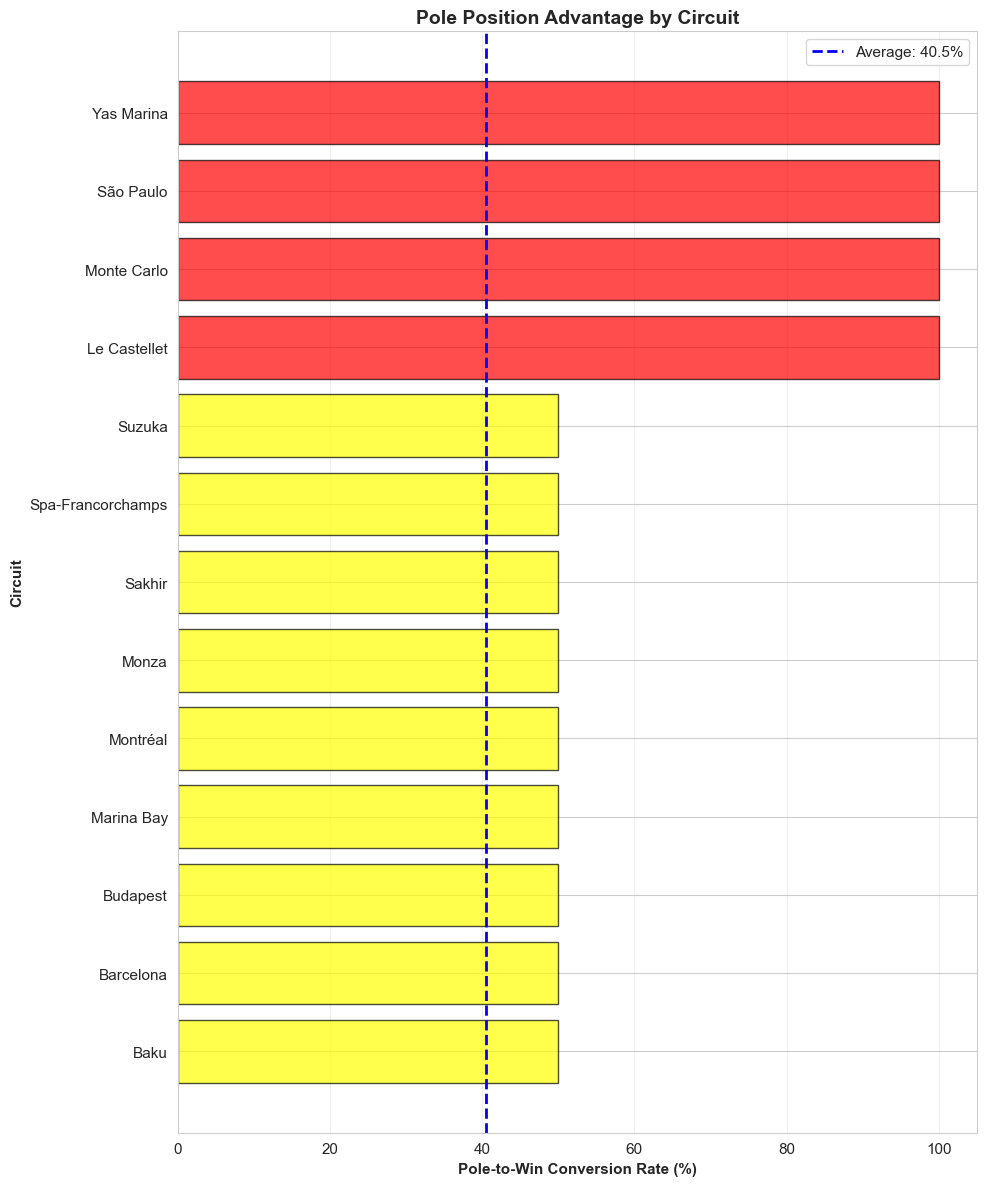

In [6]:
# Pole win rate comparison
sorted_circuits = circuit_df[circuit_df['pole_win_rate'] > 0].sort_values('pole_win_rate', ascending=True)

fig, ax = plt.subplots(figsize=(10, 12))

colors = ['green' if x < 40 else 'yellow' if x < 70 else 'red' 
          for x in sorted_circuits['pole_win_rate']]

ax.barh(sorted_circuits['circuit'], sorted_circuits['pole_win_rate'], 
        color=colors, edgecolor='black', alpha=0.7)

overall_avg = circuit_df['pole_win_rate'].mean()
ax.axvline(overall_avg, color='blue', linestyle='--', linewidth=2, 
           label=f'Average: {overall_avg:.1f}%')

ax.set_xlabel('Pole-to-Win Conversion Rate (%)', fontweight='bold')
ax.set_ylabel('Circuit', fontweight='bold')
ax.set_title('Pole Position Advantage by Circuit', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

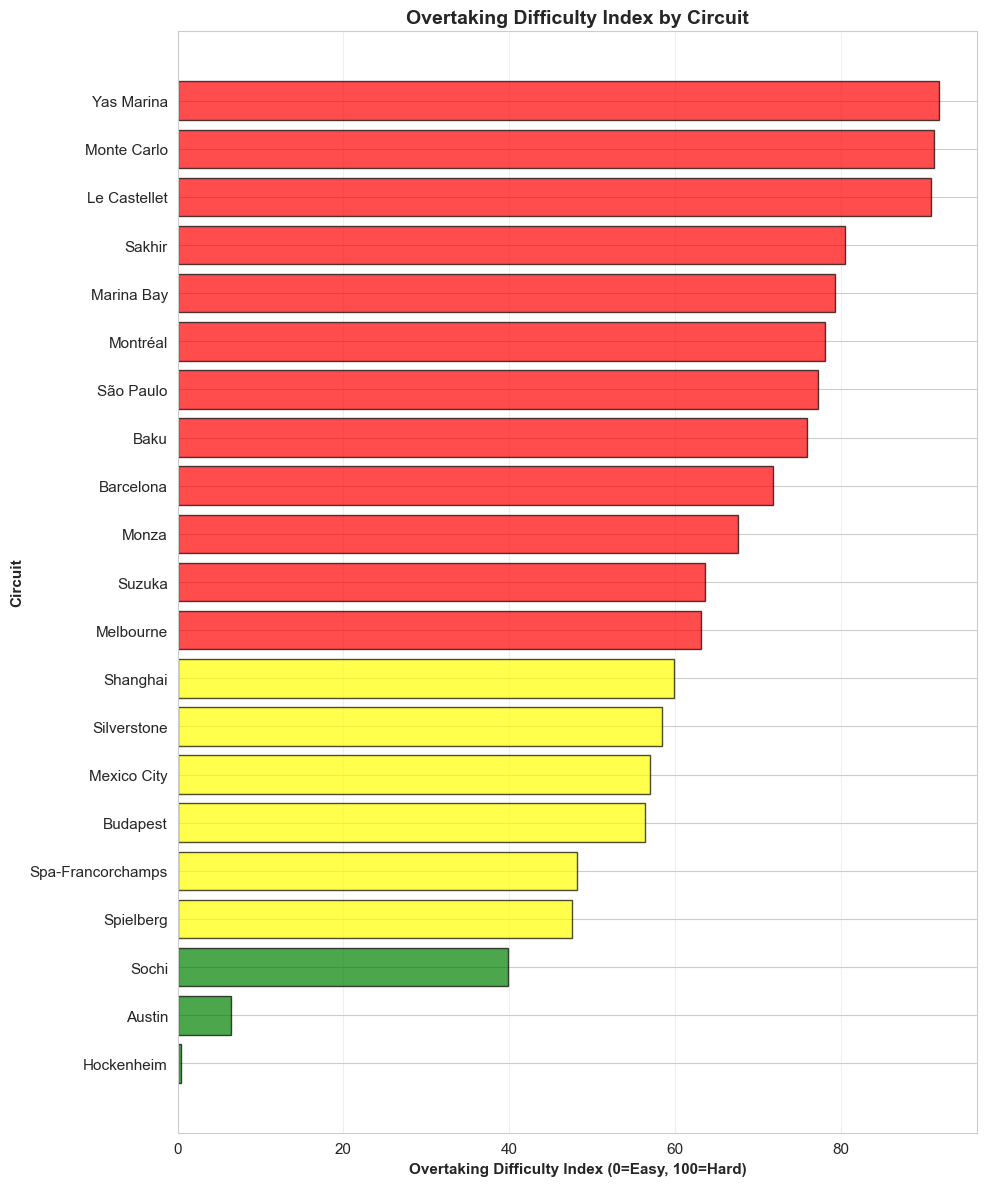


Top 5 Easiest Circuits for Overtaking:
          circuit  overtaking_difficulty
       Hockenheim               0.446131
           Austin               6.425469
            Sochi              39.851813
        Spielberg              47.520148
Spa-Francorchamps              48.210570

Top 5 Hardest Circuits for Overtaking:
     circuit  overtaking_difficulty
  Marina Bay              79.346379
      Sakhir              80.508118
Le Castellet              90.902333
 Monte Carlo              91.219335
  Yas Marina              91.827869


In [7]:
# Overtaking Difficulty Index
# Normalize metrics to 0-100 scale
def normalize_metric(series, higher_is_harder=True):
    min_val = series.min()
    max_val = series.max()
    normalized = (series - min_val) / (max_val - min_val) * 100
    if not higher_is_harder:
        normalized = 100 - normalized
    return normalized

# Calculate components
circuit_df['correlation_score'] = normalize_metric(circuit_df['grid_finish_correlation'], True)
circuit_df['variance_score'] = normalize_metric(circuit_df['variance_pos_change'], False)
circuit_df['pole_score'] = normalize_metric(circuit_df['pole_win_rate'], True)

# Combined index
circuit_df['overtaking_difficulty'] = (
    circuit_df['correlation_score'] + 
    circuit_df['variance_score'] + 
    circuit_df['pole_score']
) / 3

sorted_difficulty = circuit_df.sort_values('overtaking_difficulty', ascending=True)

fig, ax = plt.subplots(figsize=(10, 12))

colors_difficulty = ['green' if x < 40 else 'yellow' if x < 60 else 'red' 
                     for x in sorted_difficulty['overtaking_difficulty']]

ax.barh(sorted_difficulty['circuit'], sorted_difficulty['overtaking_difficulty'],
        color=colors_difficulty, edgecolor='black', alpha=0.7)

ax.set_xlabel('Overtaking Difficulty Index (0=Easy, 100=Hard)', fontweight='bold')
ax.set_ylabel('Circuit', fontweight='bold')
ax.set_title('Overtaking Difficulty Index by Circuit', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nTop 5 Easiest Circuits for Overtaking:")
print(sorted_difficulty.head(5)[['circuit', 'overtaking_difficulty']].to_string(index=False))

print("\nTop 5 Hardest Circuits for Overtaking:")
print(sorted_difficulty.tail(5)[['circuit', 'overtaking_difficulty']].to_string(index=False))

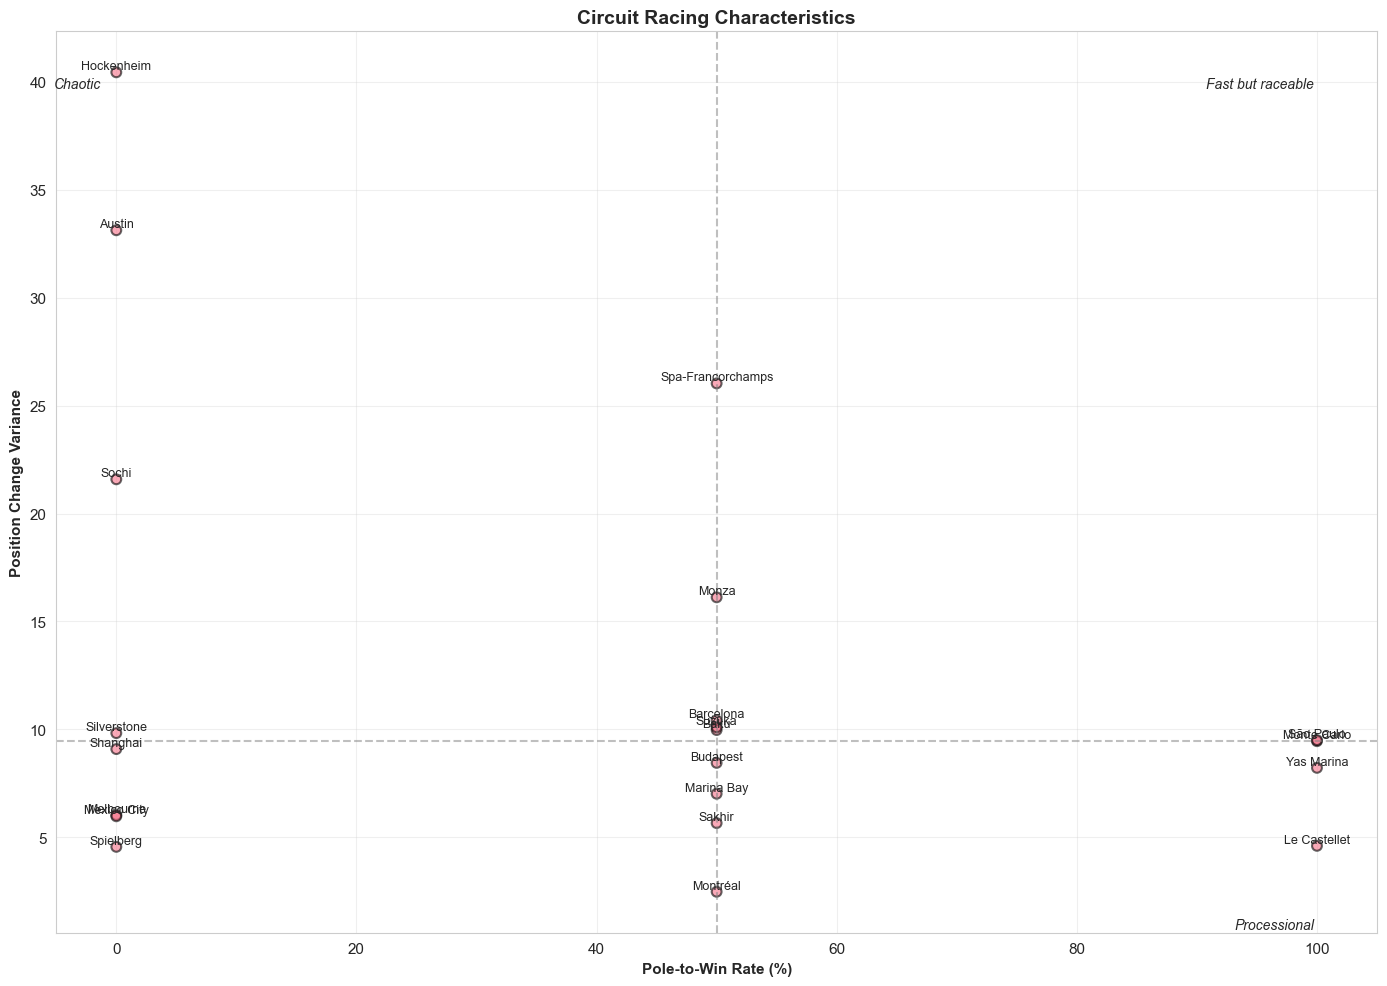

In [8]:
# Circuit characteristics scatter plot
fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(circuit_df['pole_win_rate'], 
                     circuit_df['variance_pos_change'],
                     s=circuit_df['num_races'] * 50,
                     alpha=0.6, edgecolors='black', linewidths=1.5)

# Label circuits
for idx, row in circuit_df.iterrows():
    ax.annotate(row['circuit'], 
                (row['pole_win_rate'], row['variance_pos_change']),
                fontsize=9, ha='center', va='bottom')

# Add quadrant lines
median_pole = circuit_df['pole_win_rate'].median()
median_variance = circuit_df['variance_pos_change'].median()

ax.axvline(median_pole, color='gray', linestyle='--', alpha=0.5)
ax.axhline(median_variance, color='gray', linestyle='--', alpha=0.5)

# Quadrant labels
ax.text(ax.get_xlim()[1] * 0.95, ax.get_ylim()[1] * 0.95, 
        'Fast but raceable', ha='right', va='top', fontsize=10, style='italic')
ax.text(ax.get_xlim()[0] * 1.05, ax.get_ylim()[1] * 0.95, 
        'Chaotic', ha='left', va='top', fontsize=10, style='italic')
ax.text(ax.get_xlim()[1] * 0.95, ax.get_ylim()[0] * 1.05, 
        'Processional', ha='right', va='bottom', fontsize=10, style='italic')

ax.set_xlabel('Pole-to-Win Rate (%)', fontweight='bold')
ax.set_ylabel('Position Change Variance', fontweight='bold')
ax.set_title('Circuit Racing Characteristics', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

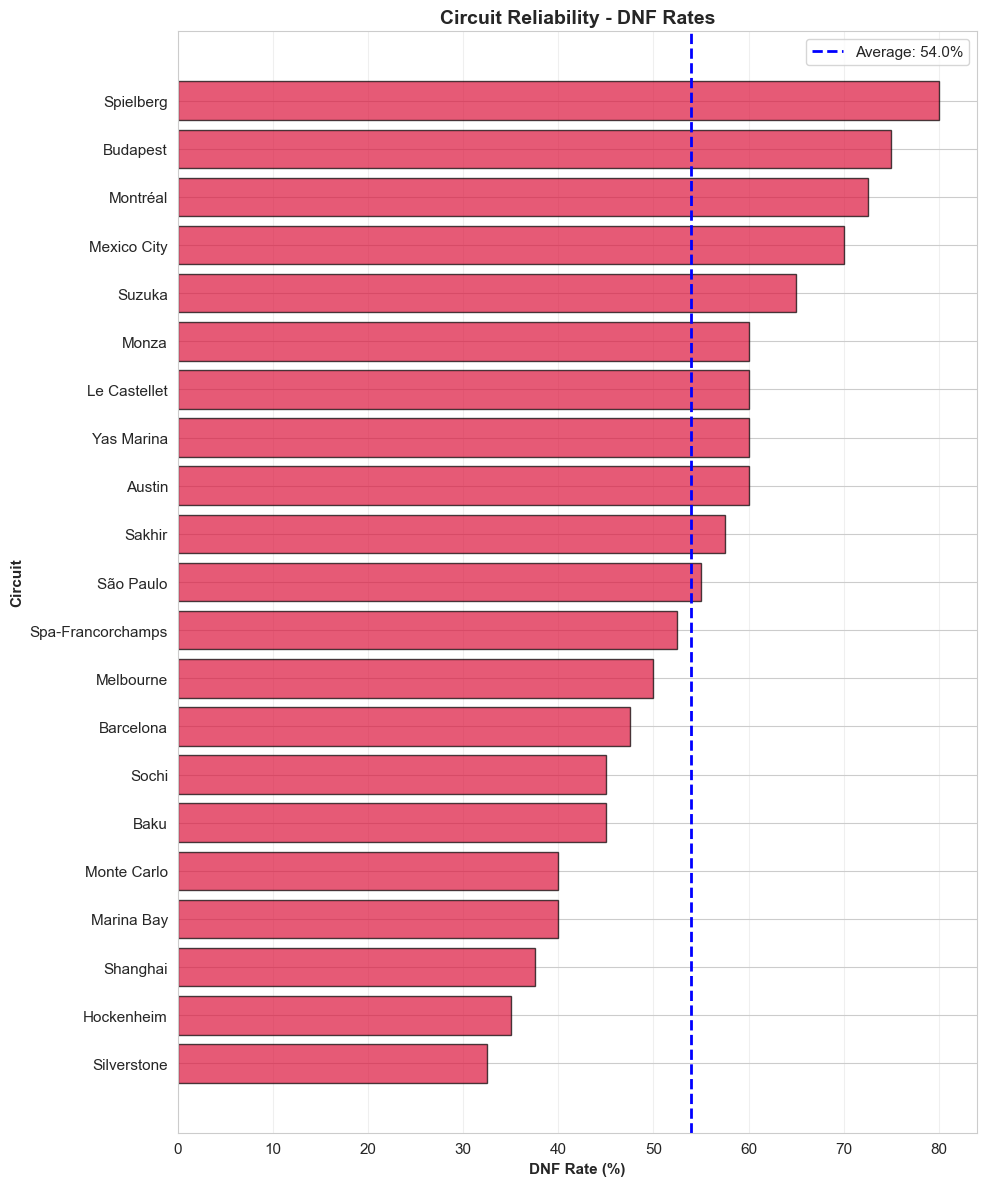

In [9]:
# DNF rate by circuit
sorted_dnf = circuit_df.sort_values('dnf_rate', ascending=True)

fig, ax = plt.subplots(figsize=(10, 12))

ax.barh(sorted_dnf['circuit'], sorted_dnf['dnf_rate'],
        color='crimson', edgecolor='black', alpha=0.7)

overall_dnf = df_all['is_dnf'].mean() * 100
ax.axvline(overall_dnf, color='blue', linestyle='--', linewidth=2,
           label=f'Average: {overall_dnf:.1f}%')

ax.set_xlabel('DNF Rate (%)', fontweight='bold')
ax.set_ylabel('Circuit', fontweight='bold')
ax.set_title('Circuit Reliability - DNF Rates', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [14]:
# Statistical testing - pre vs post 2022
from scipy.stats import ttest_ind

print("\nStatistical Tests (Pre vs Post 2022):")
print("="*70)

# Position change variance test
era1_pos_change = era1_data['position_change'].values
era2_pos_change = era2_data['position_change'].values

t_stat, p_value = ttest_ind(era1_pos_change, era2_pos_change)

print(f"\nPosition Change Variance:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"  Result: Significantly different (p < 0.05)")
else:
    print(f"  Result: Not significantly different (p >= 0.05)")

# Pole advantage test (convert to binary: won from pole or not)
era1_pole = era1_data[era1_data['GridPosition'] == 1]['Position'].values
era2_pole = era2_data[era2_data['GridPosition'] == 1]['Position'].values

if len(era1_pole) > 0 and len(era2_pole) > 0:
    t_stat_pole, p_value_pole = ttest_ind(era1_pole, era2_pole)
    
    print(f"\nPole Finish Position:")
    print(f"  t-statistic: {t_stat_pole:.4f}")
    print(f"  p-value: {p_value_pole:.4f}")
    if p_value_pole < 0.05:
        print(f"  Result: Pole advantage significantly changed (p < 0.05)")
    else:
        print(f"  Result: Pole advantage not significantly changed (p >= 0.05)")

print("\n" + "="*70)


Statistical Tests (Pre vs Post 2022):

Position Change Variance:
  t-statistic: nan
  p-value: nan
  Result: Not significantly different (p >= 0.05)



/Users/ritwik/Projects/Vantage/venv/lib/python3.13/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


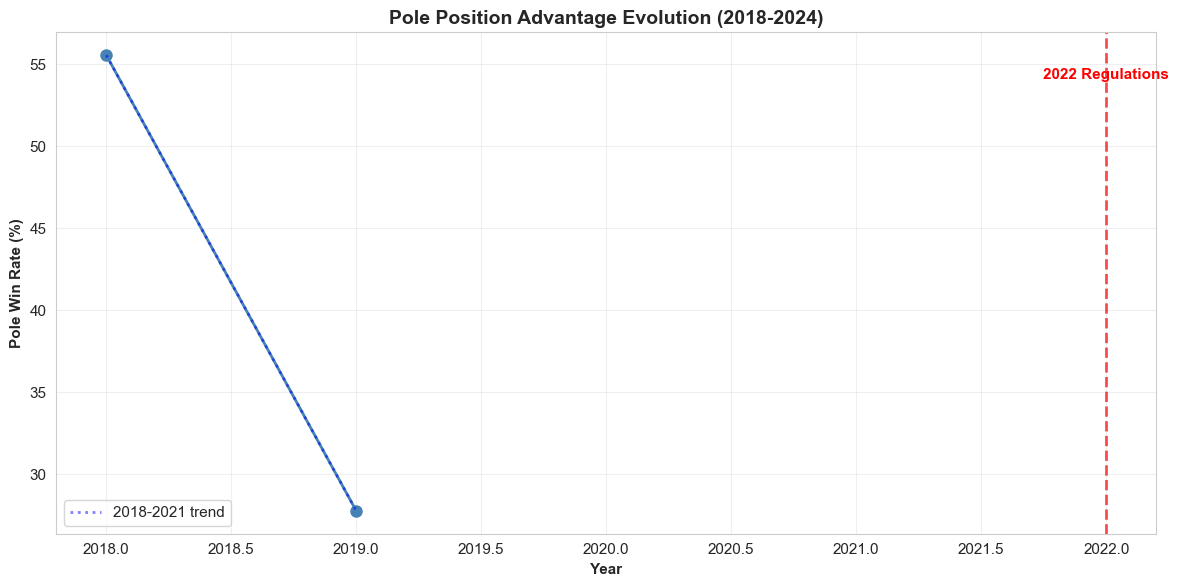


Yearly pole win rates:
 year  pole_win_rate
 2018      55.555556
 2019      27.777778


In [15]:
# Pole win rate evolution year by year
yearly_pole = []

for year in sorted(df_finished['year'].unique()):
    year_data = df_finished[df_finished['year'] == year]
    pole_data = year_data[year_data['GridPosition'] == 1]
    
    if len(pole_data) > 0:
        wins = (pole_data['Position'] == 1).sum()
        rate = (wins / len(pole_data) * 100)
        yearly_pole.append({'year': year, 'pole_win_rate': rate})

yearly_df = pd.DataFrame(yearly_pole)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(yearly_df['year'], yearly_df['pole_win_rate'], 
        marker='o', linewidth=2, markersize=8, color='steelblue')

# Mark regulation change
ax.axvline(2022, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.text(2022, ax.get_ylim()[1] * 0.95, '2022 Regulations', 
        ha='center', fontweight='bold', color='red', fontsize=11)

# Add trend lines for each era
era1_years = yearly_df[yearly_df['year'] < 2022]
era2_years = yearly_df[yearly_df['year'] >= 2022]

if len(era1_years) > 1:
    z1 = np.polyfit(era1_years['year'], era1_years['pole_win_rate'], 1)
    p1 = np.poly1d(z1)
    ax.plot(era1_years['year'], p1(era1_years['year']), 
            'b:', alpha=0.5, linewidth=2, label='2018-2021 trend')

if len(era2_years) > 1:
    z2 = np.polyfit(era2_years['year'], era2_years['pole_win_rate'], 1)
    p2 = np.poly1d(z2)
    ax.plot(era2_years['year'], p2(era2_years['year']), 
            'r:', alpha=0.5, linewidth=2, label='2022-2024 trend')

ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Pole Win Rate (%)', fontweight='bold')
ax.set_title('Pole Position Advantage Evolution (2018-2024)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nYearly pole win rates:")
print(yearly_df.to_string(index=False))

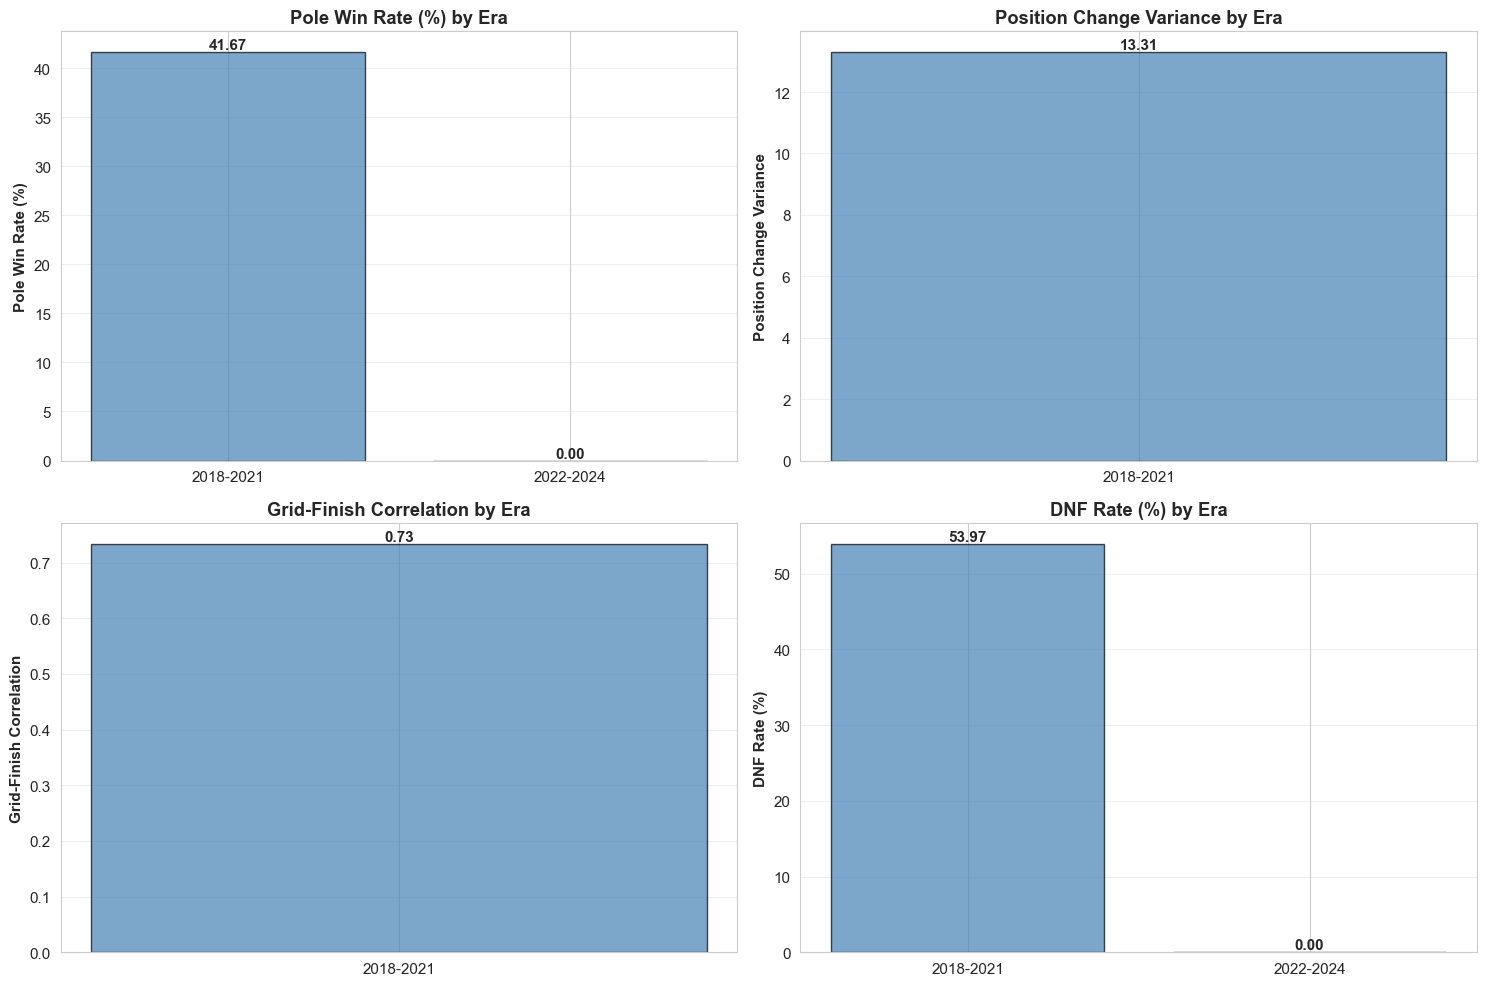

In [16]:
# Visual comparison of eras
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metric_names = ['pole_win_rate', 'pos_change_variance', 'grid_finish_corr', 'dnf_rate']
titles = ['Pole Win Rate (%)', 'Position Change Variance', 
          'Grid-Finish Correlation', 'DNF Rate (%)']

for idx, (metric, title) in enumerate(zip(metric_names, titles)):
    ax = axes[idx // 2, idx % 2]
    
    eras = list(metrics.keys())
    values = [metrics[era][metric] for era in eras]
    
    bars = ax.bar(eras, values, color=['steelblue', 'coral'], 
                  edgecolor='black', alpha=0.7)
    
    ax.set_ylabel(title, fontweight='bold')
    ax.set_title(f'{title} by Era', fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
# Split data by regulation era
era1_data = df_finished[df_finished['year'] < 2022]  # 2018-2021
era2_data = df_finished[df_finished['year'] >= 2022]  # 2022-2024

print("Regulation Era Split:")
print(f"Era 1 (2018-2021): {len(era1_data)} finishes")
print(f"Era 2 (2022-2024): {len(era2_data)} finishes")

# Calculate metrics for each era
metrics = {}

for era_name, era_data in [('2018-2021', era1_data), ('2022-2024', era2_data)]:
    # Pole win rate
    pole_data = era_data[era_data['GridPosition'] == 1]
    pole_wins = (pole_data['Position'] == 1).sum()
    pole_win_rate = (pole_wins / len(pole_data) * 100) if len(pole_data) > 0 else 0
    
    # Position change variance
    pos_change_var = era_data['position_change'].var()
    
    # Grid-finish correlation
    correlation = era_data['GridPosition'].corr(era_data['Position'])
    
    # DNF rate
    era_all = df_all[df_all['year'].isin(era_data['year'].unique())]
    dnf_rate = (era_all['is_dnf'].sum() / len(era_all) * 100) if len(era_all) > 0 else 0
    
    metrics[era_name] = {
        'pole_win_rate': pole_win_rate,
        'pos_change_variance': pos_change_var,
        'grid_finish_corr': correlation,
        'dnf_rate': dnf_rate
    }

print("\nEra Comparison:")
print("="*70)

for metric_name in ['pole_win_rate', 'pos_change_variance', 'grid_finish_corr', 'dnf_rate']:
    era1_val = metrics['2018-2021'][metric_name]
    era2_val = metrics['2022-2024'][metric_name]
    change = era2_val - era1_val
    pct_change = (change / era1_val * 100) if era1_val != 0 else 0
    
    print(f"\n{metric_name.replace('_', ' ').title()}:")
    print(f"  2018-2021: {era1_val:.2f}")
    print(f"  2022-2024: {era2_val:.2f}")
    print(f"  Change: {change:+.2f} ({pct_change:+.1f}%)")

Regulation Era Split:
Era 1 (2018-2021): 359 finishes
Era 2 (2022-2024): 0 finishes

Era Comparison:

Pole Win Rate:
  2018-2021: 41.67
  2022-2024: 0.00
  Change: -41.67 (-100.0%)

Pos Change Variance:
  2018-2021: 13.31
  2022-2024: nan
  Change: +nan (+nan%)

Grid Finish Corr:
  2018-2021: 0.73
  2022-2024: nan
  Change: +nan (+nan%)

Dnf Rate:
  2018-2021: 53.97
  2022-2024: 0.00
  Change: -53.97 (-100.0%)


## Temporal Trends - Regulation Impact

Analyzing how 2022 regulation changes affected racing characteristics.

In [19]:
# Run analysis for each circuit
for circuit in available_circuits:
    analyze_circuit(circuit, df_all, df_finished)

NameError: name 'available_circuits' is not defined

In [ ]:
def analyze_circuit(circuit_name, data_all, data_finished):
    """
    Comprehensive analysis for a single circuit.
    """
    circuit_all = data_all[data_all['circuit'] == circuit_name]
    circuit_fin = data_finished[data_finished['circuit'] == circuit_name]
    
    if len(circuit_fin) == 0:
        print(f"No data for {circuit_name}")
        return
    
    print("="*70)
    print(f"CIRCUIT ANALYSIS: {circuit_name.upper()}")
    print("="*70)
    
    # Basic stats
    num_races = circuit_all['race_name'].nunique()
    years = sorted(circuit_all['year'].unique())
    
    print(f"\nRaces analyzed: {num_races}")
    print(f"Years: {years}")
    print(f"Total entries: {len(circuit_all)}")
    
    # Grid-to-finish heatmap
    print("\nGenerating grid-to-finish heatmap...")
    
    grid_finish_matrix = pd.crosstab(
        circuit_fin['GridPosition'],
        circuit_fin['Position'],
        normalize='index'
    ) * 100
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Heatmap
    sns.heatmap(grid_finish_matrix, cmap='YlOrRd', annot=False, 
                fmt='.0f', cbar_kws={'label': 'Frequency (%)'},
                ax=axes[0, 0])
    axes[0, 0].set_xlabel('Finish Position', fontweight='bold')
    axes[0, 0].set_ylabel('Grid Position', fontweight='bold')
    axes[0, 0].set_title(f'{circuit_name} - Grid to Finish Heatmap', fontweight='bold')
    
    # Position change distribution
    axes[0, 1].hist(circuit_fin['position_change'], bins=30, 
                    edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 1].axvline(circuit_fin['position_change'].mean(), 
                       color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0, 1].axvline(circuit_fin['position_change'].median(), 
                       color='orange', linestyle='--', linewidth=2, label='Median')
    
    overall_mean = data_finished['position_change'].mean()
    axes[0, 1].axvline(overall_mean, color='green', linestyle=':', 
                       linewidth=2, label='Overall avg')
    
    axes[0, 1].set_xlabel('Position Change', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title(f'{circuit_name} - Position Change Distribution', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # Success rates by grid position
    success_by_grid = []
    for grid_pos in range(1, 21):
        grid_data = circuit_fin[circuit_fin['GridPosition'] == grid_pos]
        if len(grid_data) > 0:
            success_by_grid.append({
                'grid': grid_pos,
                'win_pct': (grid_data['Position'] == 1).mean() * 100,
                'podium_pct': (grid_data['Position'] <= 3).mean() * 100,
                'points_pct': (grid_data['Position'] <= 10).mean() * 100
            })
    
    success_df = pd.DataFrame(success_by_grid)
    
    x = success_df['grid']
    width = 0.25
    
    axes[1, 0].bar(x - width, success_df['win_pct'], width, 
                   label='Win %', color='gold', edgecolor='black')
    axes[1, 0].bar(x, success_df['podium_pct'], width, 
                   label='Podium %', color='silver', edgecolor='black')
    axes[1, 0].bar(x + width, success_df['points_pct'], width, 
                   label='Points %', color='#cd7f32', edgecolor='black')
    
    axes[1, 0].set_xlabel('Grid Position', fontweight='bold')
    axes[1, 0].set_ylabel('Success Rate (%)', fontweight='bold')
    axes[1, 0].set_title(f'{circuit_name} - Success by Grid Position', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Pole win rate over time
    pole_by_year = []
    for year in sorted(circuit_all['year'].unique()):
        year_data = circuit_fin[circuit_fin['year'] == year]
        pole_data = year_data[year_data['GridPosition'] == 1]
        if len(pole_data) > 0:
            wins = (pole_data['Position'] == 1).sum()
            pole_by_year.append({'year': year, 'won': wins > 0})
    
    if len(pole_by_year) > 0:
        pole_df = pd.DataFrame(pole_by_year)
        pole_df['win_rate'] = pole_df['won'].astype(int) * 100
        
        axes[1, 1].plot(pole_df['year'], pole_df['win_rate'], 
                        marker='o', linewidth=2, markersize=8)
        axes[1, 1].set_xlabel('Year', fontweight='bold')
        axes[1, 1].set_ylabel('Pole Win Rate (%)', fontweight='bold')
        axes[1, 1].set_title(f'{circuit_name} - Pole Success Over Time', fontweight='bold')
        axes[1, 1].set_ylim(-10, 110)
        axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    pole_starts = circuit_fin[circuit_fin['GridPosition'] == 1]
    pole_wins = (pole_starts['Position'] == 1).sum()
    pole_win_rate = (pole_wins / len(pole_starts) * 100) if len(pole_starts) > 0 else 0
    
    top3_starts = circuit_fin[circuit_fin['GridPosition'] <= 3]
    top3_wins = (top3_starts['Position'] == 1).sum()
    total_wins = (circuit_fin['Position'] == 1).sum()
    top3_win_share = (top3_wins / total_wins * 100) if total_wins > 0 else 0
    
    avg_pos_change = circuit_fin['position_change'].abs().mean()
    
    print(f"\nKey Statistics:")
    print(f"  Pole-to-win rate: {pole_win_rate:.1f}%")
    print(f"  Top 3 grid win share: {top3_win_share:.1f}%")
    print(f"  Average position change: ±{avg_pos_change:.2f}")
    print(f"  Position change std dev: {circuit_fin['position_change'].std():.2f}")
    print(f"  Grid-finish correlation: {circuit_fin['GridPosition'].corr(circuit_fin['Position']):.3f}")
    
    print("\n" + "="*70 + "\n")

In [ ]:
# Select circuits for deep dive
deep_dive_circuits = ['Monaco', 'Monza', 'Bahrain', 'Singapore', 'Spa-Francorchamps', 'Interlagos']

# Check which are actually in our dataset
available_circuits = [c for c in deep_dive_circuits if c in df_all['circuit'].values]
print(f"Deep dive circuits available: {available_circuits}\n")

if len(available_circuits) == 0:
    print("None of the target circuits found. Available circuits:")
    print(sorted(df_all['circuit'].unique()))

## Circuit Deep Dives

Detailed analysis of key circuits representing different racing characteristics.